This notebook contains the  end to end pipeline for training and predicting on test

Here are the things we'll cover.
1. [EDA on data](#section-one)
2. [Data prep and feature generation](#section-two)
3. [TF-IDF and linear regression](#section-three)
4. [Catboost with text features](#section-four)


## Libraries 📚⬇

In [1]:
!pip install pymorphy2 -q

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from tqdm import tqdm
from tqdm.notebook import tqdm

#### TEXT PROCESSING
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from functools import lru_cache

#### MODELS
from sklearn.feature_extraction.text import TfidfVectorizer
from ast import literal_eval
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

import statsmodels.api as sm
from scipy.stats import norm
from scipy.sparse import hstack
import scipy.stats as stats

#### SETTINGS
plt.rcParams["figure.figsize"] = [10, 6]
tqdm.pandas()
import warnings
warnings.filterwarnings('ignore')
import random
random.seed(42)
np.random.seed(42)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


<a id="section-one"></a>
# EDA on data

In [3]:
# Import data
df_train = pd.read_csv('../input/hse-2nd-step-in-nlp-bootcamp/vacancies_train.csv')
df_test = pd.read_csv('../input/hse-2nd-step-in-nlp-bootcamp/vacancies_test.csv', index_col=0)

In [4]:
df_train.head()

,name,experience,schedule,employment,description,key_skills,salary
0,Водитель-экспедитор,От 3 до 6 лет,Полный день,Полная занятость,"Водитель-экспедитор категории В,С (а\м ГАЗЕЛЬ ...",[],42500.0
1,Кладовщик-комплектовщик/оператор 1С,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Списывание материалов в произво...,"['знание пк', 'работа в 1С', 'Работа в команде...",50000.0
2,"Продавец магазина ""Магнит"" (Кировский р-он, В....",Нет опыта,Сменный график,Полная занятость,"В крупнейшую Федеральную сеть магазинов ""Магни...",[],31500.0
3,Администратор магазина (ТЦ Spar),От 1 года до 3 лет,Полный день,Полная занятость,Крупная федеральная сеть магазинов мужской и ж...,[],36700.0
4,Мойщик посуды (кулинария),Нет опыта,Сменный график,Полная занятость,Обязанности: Уборка производственных площадей...,"['Пользователь ПК', 'Грамотная речь', 'Работа ...",37000.0


<AxesSubplot:xlabel='salary', ylabel='Count'>

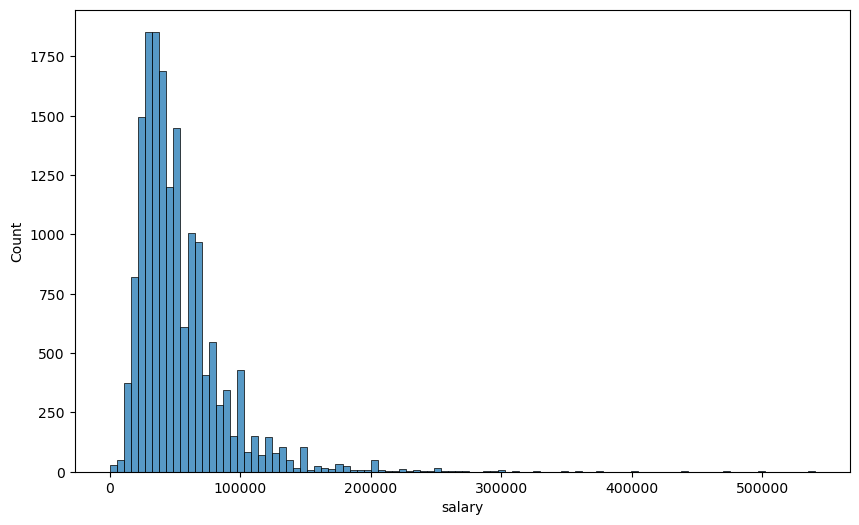

In [5]:
sns.histplot(df_train.salary, bins=100)

<AxesSubplot:xlabel='salary', ylabel='Count'>

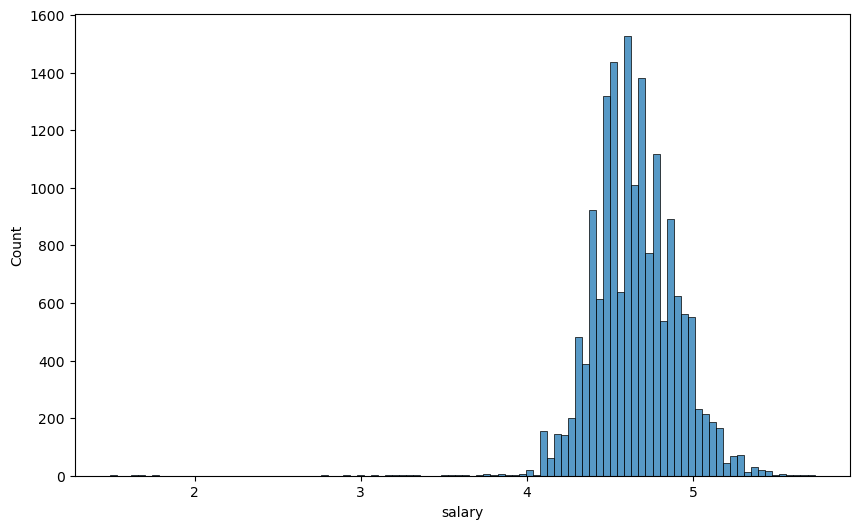

In [6]:
sns.histplot(np.log10(df_train.salary + 1), bins=100)

In [7]:
df_train[df_train['salary'] < 1000].shape[0]

7

In [8]:
df_train[df_train['salary'] < 1000]

,name,experience,schedule,employment,description,key_skills,salary
163,Ведущий специалист/Руководитель тендерного отдела,От 3 до 6 лет,Полный день,Полная занятость,Компания-поставщик медицинских расходных матер...,"['Государственные закупки', 'Тендеры', 'Участи...",55.0
1904,Официант на мероприятия,Нет опыта,Гибкий график,Частичная занятость,Группа компаний WIND TO GO! - это собственный ...,"['Работа в команде', 'Грамотная речь', 'Органи...",800.0
2641,Продавец консультант/старший(ТЦ Эльгрин),От 1 года до 3 лет,Полный день,Полная занятость,Должностные обязанности: - консультирование кл...,"['Клиентоориентированность', 'Мерчандайзинг', ...",30.0
9696,Фрезеровщик,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности: Обработка деталей на горизонталь...,"['Пользователь ПК', 'Работа в команде', 'Точно...",60.0
13252,Уборщица/уборщик игрового зала,Нет опыта,Сменный график,Полная занятость,Работа в ночные смены Обязанности: осуществля...,[],600.0
13491,Инженер-экономист,От 1 года до 3 лет,Полный день,Полная занятость,Обязанности Работа с ресурсоснабжающими органи...,"['Работа с большим объемом информации', 'Делов...",45.0
16235,Комплектовщик (Тарасовка),Нет опыта,Сменный график,Полная занятость,Сервис доставки продуктов Ленточка приглашает ...,[],44.0


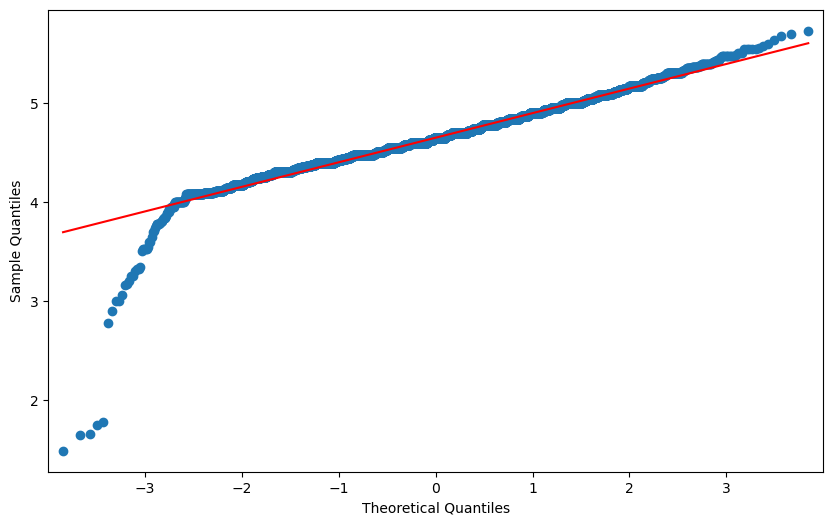

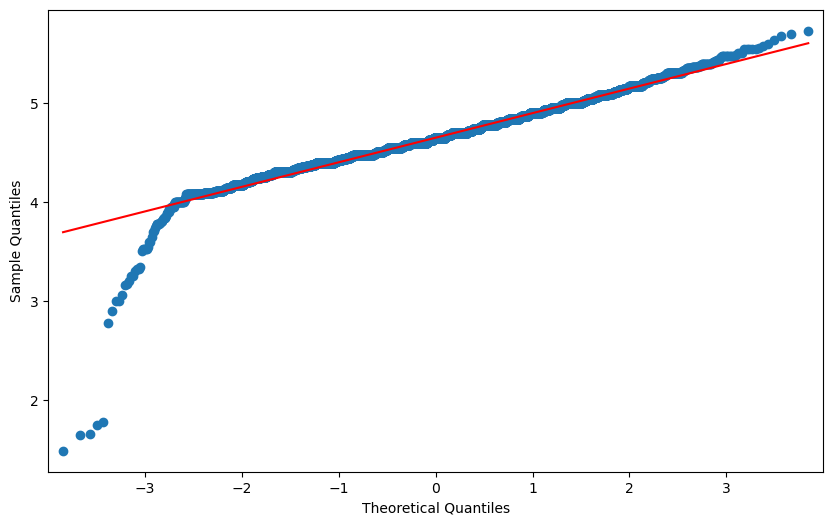

In [9]:
sm.qqplot(np.log10(df_train.salary + 1), line='s')

# Data prep and feature generation<a id="section-two">

## Correct errors in salary values

In [10]:
df_train['salary'][df_train['salary'] < 200] = df_train['salary'][df_train['salary'] < 200].apply(lambda x: x * 1000)

## Create a text column 

In [11]:
df_train['text'] = df_train.name + ' ' + df_train.description

## Clean text

In [12]:
stop_words = set(stopwords.words('russian'))
morph = MorphAnalyzer()
@lru_cache(maxsize=128)

# function for cleaning descriptions
def clean_text(text):
    text = re.sub(r'http\S+', ' ', text)# remove links
    text = re.sub(r'[^\w\s]', ' ', text)# remove punctuation
    text = word_tokenize(text.lower()) # convert to lowercase and tokenize by words
    # normalize tokens, remove stop words and short tokens
    text = [morph.normal_forms(token)[0] for token in text 
            if token not in stop_words and len(token) > 2]
    text = " ".join(text) # return a string
    return text

In [13]:
regenerate = False 

if regenerate: 
    df_train['clean_text'] = df_train.text.progress_apply(clean_text) 
    df_train['clean_name'] = df_train.name.progress_apply(clean_text)
    df_train['clean_skills'] = df_train.key_skills.progress_apply(clean_text)

    df_train[['clean_text',
              'clean_name',
              'clean_skills']].to_csv('train_cleaned_text_cols.csv', index=False) 
    
else:
    df_train_clean_text_cols = pd.read_csv('../input/2nd-step-cleaned-text/train_cleaned_text_cols.csv')
    df_train = pd.concat([df_train, df_train_clean_text_cols], axis=1)

## Some text features

In [14]:
def find_numbers(df, column_name):
    # find numbers that look like salariy in the descriptions
    
    df['found_numbers'] = df[column_name].str.extractall('(\d{3,4}00+)')\
        .astype(int).groupby(level=0).agg(list)
    # Drop any rows where no numbers were found
    new_df = df.dropna(subset=['found_numbers'])
    return new_df

def avg_max_func(x):
    '''if we find 2 or more numbers it could mean 
    we have salary range or some bonuses or incentives'''
    if isinstance(x, list):
        return pd.Series([sum(x)/len(x), max(x), min(x)])
    else:
        return pd.Series([x, x, x])

In [15]:
find_numbers(df_train, 'description')
df_train[['av_num', 'max_num', 'min_num']] = df_train['found_numbers'].apply(avg_max_func)

key_skills is a list of strings that is saved as a string

In [16]:
df_train['key_skills_list'] = df_train['key_skills'].apply(literal_eval)
df_train['num_skills'] = df_train['key_skills_list'].apply(len)

In [17]:
df_train['perc'] = df_train['description'].str.contains('процент').apply(int)
df_train['%'] = df_train['description'].str.contains('%').apply(int)
df_train['1s_text'] = df_train['description'].str.contains(r'1\s*[CcСс][^\S\n]*').apply(int)
df_train['1s_skills'] = df_train['key_skills'].str.contains(r'1\s*[CcСс][^\S\n]*').apply(int)
df_train['en_text'] = df_train['description'].str.contains(r'[A-Za-z]').apply(int)
df_train['en_skills'] = df_train['key_skills'].str.contains(r'[A-Za-z]').apply(int)
df_train['clean_skills'] = df_train['clean_skills'].fillna('')

In [18]:
df_train.columns

Index(['name', 'experience', 'schedule', 'employment', 'description',
       'key_skills', 'salary', 'text', 'clean_text', 'clean_name',
       'clean_skills', 'found_numbers', 'av_num', 'max_num', 'min_num',
       'key_skills_list', 'num_skills', 'perc', '%', '1s_text', '1s_skills',
       'en_text', 'en_skills'],
      dtype='object')

In [19]:
categorical_features = [
    'experience',
    'schedule',
    'employment'
]

numerical_features = [
    'av_num', 
    'max_num', 
    'min_num',
    'num_skills'
]
features_to_drop = [
    'key_skills_list',
    'description',
    'found_numbers',
    'name',
    'key_skills', 
    'clean_name',         
    'clean_skills',      
    'clean_text',         
    'text',           
    'key_skills_list'  
]


# TF-IDF and linear regression<a id="section-three">

In [20]:
tfidf_words = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2),
    lowercase=True,
    sublinear_tf=True
)
tfidf_chars = TfidfVectorizer(
    analyzer='char',
    ngram_range=(1, 5),
    lowercase=True,
    sublinear_tf=True
)

In [21]:
mlb = MultiLabelBinarizer()

# fit_transform on the column will return a numpy array with binary encoding
X_mlb = mlb.fit_transform(df_train['key_skills_list'])
X_mlb.shape

(16629, 4357)

In [22]:
X_tfidf_words = tfidf_words.fit_transform(df_train['clean_text'])
X_tfidf_chars = tfidf_chars.fit_transform(df_train['text'])

In [23]:
X_tfidf_chars.shape

(16629, 890609)

In [24]:
X_tfidf_words.shape

(16629, 516698)

In [25]:
preprocessor = ColumnTransformer(
    transformers=[
    #('tfidf_words', tfidf_words, ['clean_text']),
    #('tfidf_chars', tfidf_chars, ['text']),
    ('categorical', OneHotEncoder(), categorical_features),
    #('skills_list', MyMultiLabelBinarizer(), ['key_skills_list']),
    ('numerical', MinMaxScaler(), numerical_features), 
    ('drop', 'drop', features_to_drop)
    ],
    remainder='passthrough',
)

X_proc = preprocessor.fit_transform(df_train.drop(columns=['salary']))
X_proc.shape

(16629, 23)

In [26]:
X_train = hstack([
    X_tfidf_words,
    X_tfidf_chars,
    X_mlb,
    X_proc
]).tocsr()
y_train = df_train['salary']
X_train.shape, y_train.shape

((16629, 1411687), (16629,))

In [27]:
nan_rows = np.isnan(X_train.data)
inf_rows = np.isinf(X_train.data)

# Replace NaN or infinity values with a finite number (e.g., 0)
X_train.data[nan_rows] = 0
X_train.data[inf_rows] = 0


In [28]:
model = Ridge(solver="sag", fit_intercept=True, random_state=42)
model.fit(X_train, y_train)

Ridge(random_state=42, solver='sag')

In [29]:
model.score(X_train, y_train)

0.9255747370963487

## Making a submission

In [30]:
def pred_to_csv(pred, name):
    a = pd.Series(pred, name="salary")
    a.index.name = "id"
    a.to_csv(f"/kaggle/working/{name}.csv")

## Preparing test 

In [31]:
df_test['text'] = df_test.name + ' ' + df_test.description

In [32]:
regenerate = False  # Флаг, который ты легко можешь переключать

if regenerate: # При первом проходе готовим данные
    df_test['clean_text'] = df_test.text.progress_apply(clean_text) # Подготавливаем признаки для трейна
    df_test['clean_name'] = df_test.name.progress_apply(clean_text)
    df_test['clean_skills'] = df_test.key_skills.progress_apply(clean_text)

    df_test[['clean_text',
              'clean_name',
              'clean_skills']].to_csv('test_cleaned_text_cols.csv', index=False) # Сохраняем
    
else: # При повторном проходе можно сэкономить ваше бесценное время
    df_test_clean_text_cols = pd.read_csv('../input/2nd-step-cleaned-text/test_cleaned_text_cols.csv')
    df_test = pd.concat([df_test, df_test_clean_text_cols], axis=1)

In [33]:
find_numbers(df_test, 'description')
df_test[['av_num', 'max_num', 'min_num']] = df_test['found_numbers'].apply(avg_max_func)
df_test['key_skills_list'] = df_test['key_skills'].apply(literal_eval)
df_test['num_skills'] = df_test['key_skills_list'].apply(len)
df_test['perc'] = df_test['description'].str.contains('процент').apply(int)
df_test['%'] = df_test['description'].str.contains('%').apply(int)
df_test['1s_text'] = df_test['description'].str.contains(r'1\s*[CcСс][^\S\n]*').apply(int)
df_test['1s_skills'] = df_test['key_skills'].str.contains(r'1\s*[CcСс][^\S\n]*').apply(int)
df_test['en_text'] = df_test['description'].str.contains(r'[A-Za-z]').apply(int)
df_test['en_skills'] = df_test['key_skills'].str.contains(r'[A-Za-z]').apply(int)
df_test['clean_skills'] = df_test['clean_skills'].fillna('')

In [34]:
X_test_mlb = mlb.transform(df_test['key_skills_list'])
X_test_tfidf_words = tfidf_words.transform(df_test['clean_text'])
X_test_tfidf_chars = tfidf_chars.transform(df_test['text'])
X_test_proc = preprocessor.transform(df_test)
X_test_mlb.shape, X_test_tfidf_words.shape, X_test_tfidf_chars.shape, X_test_proc.shape

((5543, 4357), (5543, 516698), (5543, 890609), (5543, 23))

In [35]:
X_test = hstack([
    X_test_tfidf_words,
    X_test_tfidf_chars,
    X_test_mlb,
    X_test_proc
]).tocsr()

In [36]:
nan_rows = np.isnan(X_test.data)
inf_rows = np.isinf(X_test.data)


X_test.data[nan_rows] = 0
X_test.data[inf_rows] = 0

## Making predictions

In [37]:
pred = model.predict(X_test)

<AxesSubplot:ylabel='Count'>

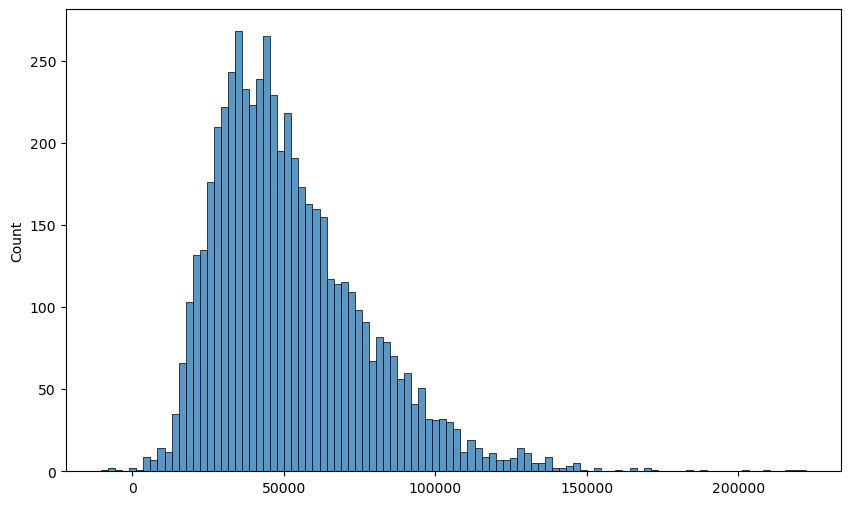

In [38]:
sns.histplot(pred, bins=100)

In [39]:
pred_to_csv(pred, "ridge_tfidf") # LB 0.51644

# Catboost with text features<a id="section-four">

In [40]:
!pip install catboost -q
print('Done!')

Done!


In [41]:
from catboost import Pool, CatBoostRegressor

In [42]:
text_features = [
    'clean_name', 
    'text', 
    'clean_text', 
    'clean_skills'
]

features_to_drop_catboost = [
    'key_skills_list',
    'description',
    'found_numbers',
    'name',
    'key_skills',                     
    'key_skills_list'      
]

In [43]:
df_train_mlb = pd.DataFrame(X_mlb, columns=mlb.classes_)

# concatenate the new dataframe with the original dataframe
df_train = pd.concat([df_train, df_train_mlb], axis=1)

In [44]:
from sklearn.model_selection import train_test_split
X_train_catboost, X_val_catboost, y_train_catboost, y_val_catboost = train_test_split(
    df_train.drop(columns = ['salary'] + features_to_drop_catboost),
    df_train['salary'], 
    train_size=0.95
    )

In [45]:
cat = CatBoostRegressor(
    use_best_model= True,
    learning_rate=0.03,
    task_type='GPU',
    depth = 6,
    iterations = 10000
    )

In [46]:
train_pool = Pool(
    X_train_catboost, y_train_catboost, 
    cat_features=categorical_features,
    text_features=text_features,
)

validation_pool = Pool(
    X_val_catboost, y_val_catboost, 
    cat_features=categorical_features,
    text_features=text_features,
)

In [47]:
cat.fit(
    train_pool, 
    eval_set = validation_pool,
    verbose = 200
) 

0:	learn: 34034.5817317	test: 34890.6575108	best: 34890.6575108 (0)	total: 46.1ms	remaining: 7m 40s
200:	learn: 25695.6328220	test: 28324.7168606	best: 28324.7168606 (200)	total: 7.78s	remaining: 6m 19s
400:	learn: 24340.1135046	test: 27688.5471908	best: 27688.5471908 (400)	total: 15s	remaining: 5m 58s
600:	learn: 23544.5350773	test: 27399.4324927	best: 27391.9266714 (597)	total: 21.6s	remaining: 5m 38s
800:	learn: 23032.2253980	test: 27267.6602816	best: 27261.0442601 (794)	total: 28s	remaining: 5m 21s
1000:	learn: 22729.3060651	test: 27193.3675172	best: 27192.8200478 (999)	total: 34.4s	remaining: 5m 9s
1200:	learn: 22360.8288119	test: 27117.0848445	best: 27111.3603665 (1188)	total: 40.9s	remaining: 4m 59s
1400:	learn: 22022.3392491	test: 27037.6417725	best: 27037.5368928 (1397)	total: 48.2s	remaining: 4m 55s
1600:	learn: 21697.4513035	test: 26998.7545240	best: 26996.1709422 (1579)	total: 54.8s	remaining: 4m 47s
1800:	learn: 21427.9631283	test: 26968.7151401	best: 26968.4522701 (1791)	

In [48]:
df_test_mlb = pd.DataFrame(X_test_mlb, columns=mlb.classes_)

# concatenate the new dataframe with the original dataframe
df_test = pd.concat([df_test, df_test_mlb], axis=1)

In [49]:
test_pool = Pool(
    df_test.drop(columns = features_to_drop_catboost),
    cat_features=categorical_features,
    text_features=text_features,
)

In [50]:
df_test.drop(columns = features_to_drop_catboost).shape

(5543, 4374)

In [51]:
df_train.drop(columns = features_to_drop_catboost).shape

(16629, 4375)

## Making a submission

In [52]:
pred_catboost = cat.predict(test_pool)

In [53]:
pred_to_csv(pred_catboost, "catboost") # LB 0.49764

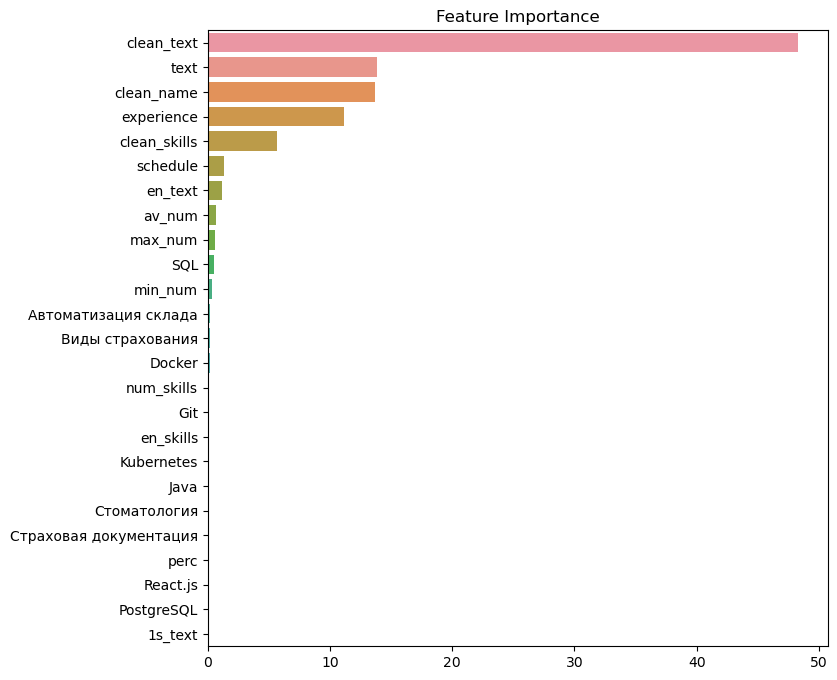

In [54]:
CAT_FI = cat.get_feature_importance()
feat_dict = {}
for col, val in sorted(zip(df_test.drop(
        columns=features_to_drop_catboost).columns, CAT_FI),
        key=lambda x: x[1], reverse=True):
    feat_dict[col] = val

feat_df = pd.DataFrame(
    {'Feature': feat_dict.keys(), 'Importance': feat_dict.values()})[:25]


values = feat_df.Importance
plt.rcParams["figure.figsize"] = (8, 8)
idx = feat_df.Feature
fig, ax = plt.subplots()
sns.barplot(y=idx, x=values).set(title='Feature Importance')
ax.set(xlabel='', ylabel='')
plt.show()